In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
df = pd.read_csv('../data/bitcoin_2017_to_2023.csv')

In [4]:
df

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.686580,1.354538e+05,258,0.893910,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.775890,1.380351e+05,317,2.245460,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.522630,3.330532e+05,451,2.708730,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.896100,4.595556e+05,483,10.229810,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.746570,1.090761e+06,686,16.504520,476955.246611
...,...,...,...,...,...,...,...,...,...,...
3125995,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,5.999993e+02,1,0.140796,599.999338
3125996,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,5.117185e+01,3,0.012008,51.171852
3125997,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1.117543e+03,2,0.261074,1117.542921
3125998,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000e+00,0,0.000000,0.000000


In [26]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [8]:
df.head()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
timestamp,,,,,,,,,
2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

In [32]:
timestep = 1

X = []
y = []
for i in range(timestep, len(scaled_data)):
    X.append(scaled_data[i - timestep:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

In [33]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [34]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:len(X)]

In [35]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [36]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
78150/78150 [==============================] - 142s 2ms/step - loss: 5.2932e-05 - val_loss: 4.0205e-07
Epoch 2/20
78150/78150 [==============================] - 143s 2ms/step - loss: 1.0271e-06 - val_loss: 1.5623e-07
Epoch 3/20
78150/78150 [==============================] - 143s 2ms/step - loss: 8.2904e-07 - val_loss: 7.7323e-08
Epoch 4/20
78150/78150 [==============================] - 143s 2ms/step - loss: 7.3017e-07 - val_loss: 5.3508e-07
Epoch 5/20
78150/78150 [==============================] - 146s 2ms/step - loss: 6.5096e-07 - val_loss: 4.7356e-07
Epoch 6/20
78150/78150 [==============================] - 147s 2ms/step - loss: 6.0758e-07 - val_loss: 1.1321e-07
Epoch 7/20
78150/78150 [==============================] - 148s 2ms/step - loss: 5.6379e-07 - val_loss: 9.1252e-08
Epoch 8/20
78150/78150 [==============================] - 150s 2ms/step - loss: 5.2423e-07 - val_loss: 8.3704e-08
Epoch 9/20
78150/78150 [==============================] - 156s 2ms/step - loss: 5.0412e-

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

19538/19538 [==============================] - 12s 602us/step


In [20]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [21]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 56.78
Test RMSE: 26.30


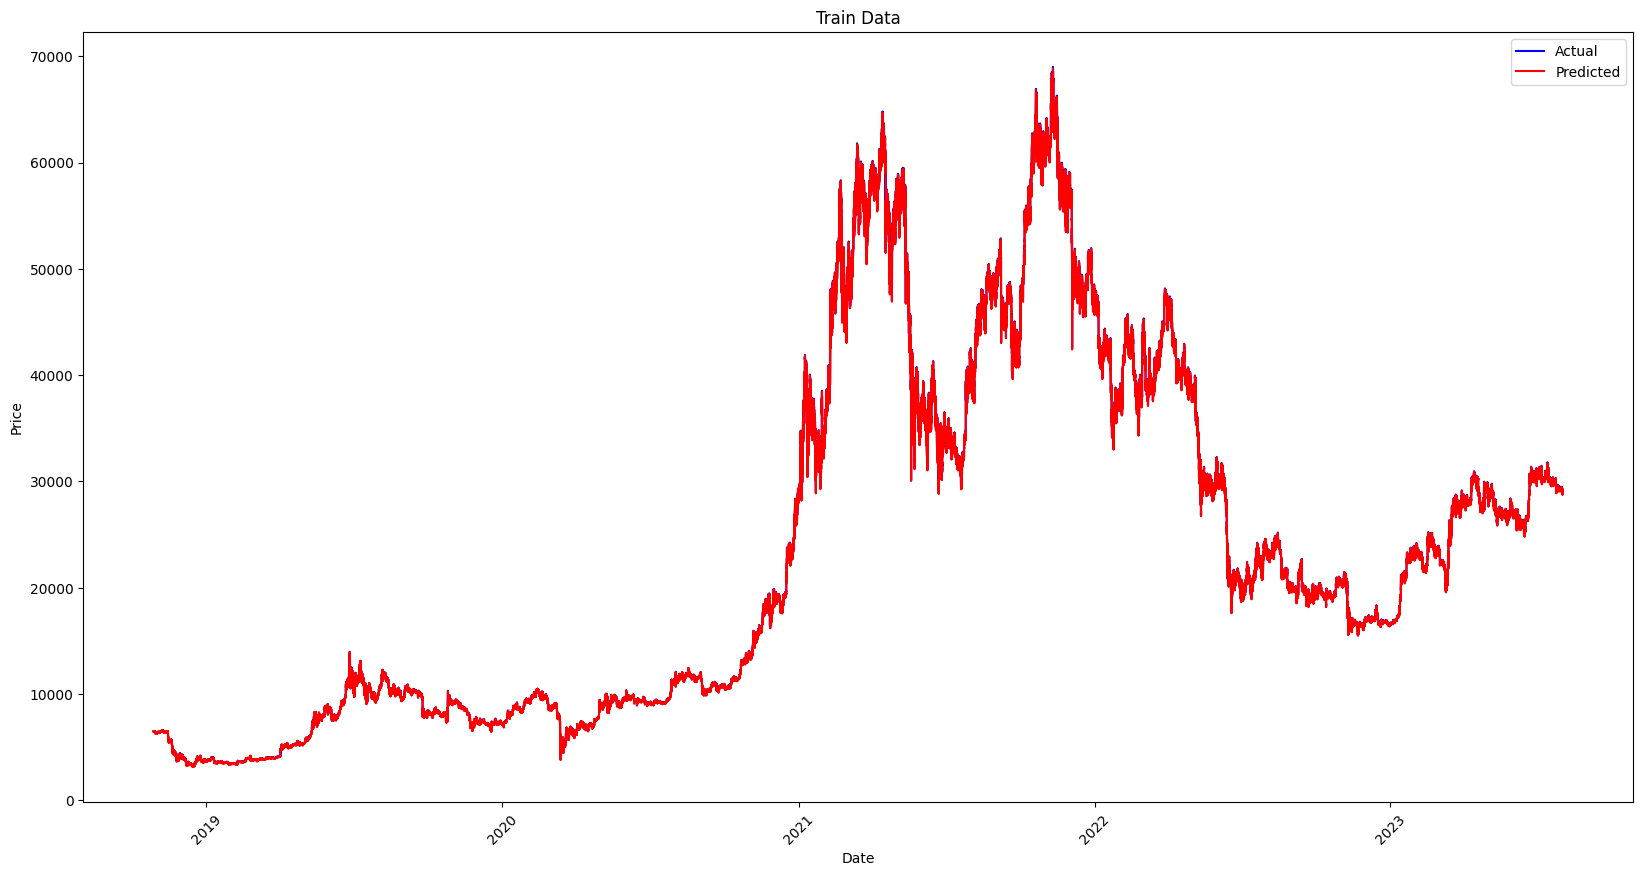

In [22]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

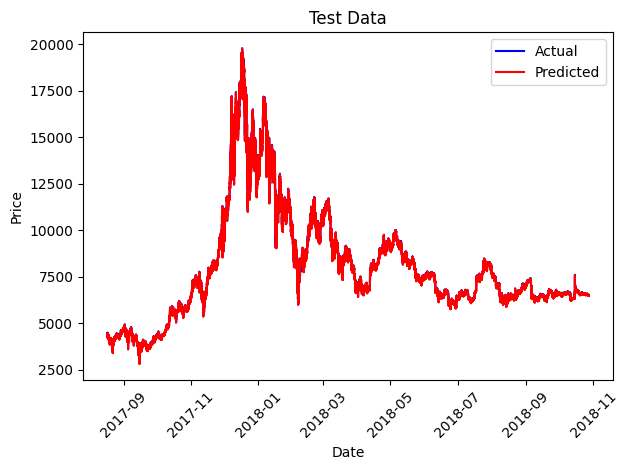

In [23]:
plt.subplot(1, 1, 1)
plt.plot(test_dates, y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates, test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [ ]:
last_1_days = scaled_data[-timestep:]
X_predict = last_1_days.reshape(1, timestep, 1)

In [ ]:
pred = model.predict(X_predict)
print(pred)

In [ ]:
# Predict the future
# future_predictions = []
# for _ in range(len(new_df)):
#     pred = model.predict(X_predict)
#     future_predictions.append(pred[0, 0])
#     pred = pred.reshape(1, 1, 1)
#     X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)
# future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))